- Required snowflake-ml-python version: >=**1.6.1**
- Last updated on: 8/6/2024

# End to end ML with Feature Store and Model Registry

This notebook demonstrates an end-to-end ML experiment cycle including feature creation, training data generation, model training and inference. The workflow touches on key Snowflake ML features including [Snowflake Feature Store](https://docs.snowflake.com/en/developer-guide/snowpark-ml/feature-store/overview), [Dataset](https://docs.snowflake.com/en/developer-guide/snowpark-ml/dataset), ML Lineage, [Snowpark ML Modeling](https://docs.snowflake.com/en/developer-guide/snowpark-ml/modeling) and [Snowflake Model Registry](https://docs.snowflake.com/en/developer-guide/snowpark-ml/model-registry/overview). 

Note: there may be a delay in the availability of the newest snowflake-ml-python package in the Snowflake Conda channel. To install the latest snowflake-ml-python package which includes all of necessary components used in this notebook, please follow the install instructions [here](https://docs.snowflake.com/LIMITEDACCESS/snowpark-ml-library-update).

**Table of contents**
- [Set up test environment](#setup-test-env)
  - [Connect to Snowflake](#connect-to-snowflake)
  - [Select your example](#select-your-example)
- [Create features with Feature Store](#create-features-with-feature-store)
  - [Initialize Feature Store](#initialize-feature-store)
  - [Register entities and feature views](#register-new-entities-and-feature-views)
  - [Examine features in Snowflake UI](#feature-store-ui)
- [Generate Training Data](#gen-training-data)
- [Train model with Snowpark ML](#train-with-snowpark-ml)
- [Log models in Model Registry](#log-models-in-model-registry)
  - [Examine model in Snowflake UI](#examine-model-in-snowflake-ui) 
- [Query lineage](#query-lineage)
- [Predict with model](#predict-with-model)
  - [Predict with local model](#predict-with-local-model)
  - [Predict with Model Registry](#predict-with-model-registry)
- [Clean up notebook](#cleanup)

<a id='setup-test-env'></a>
## Set up test environment

<a id='connect-to-snowflake'></a>
### Connect to Snowflake

Let's start with setting up our test environment. We will create a session and a schema. The schema `FS_DEMO_SCHEMA` will be used as the Feature Store. It will be cleaned up at the end of the demo. You need to fill the `connection_parameters` with your Snowflake connection information. Follow this **[guide](https://docs.snowflake.com/en/developer-guide/snowpark/python/creating-session)** for more details about how to connect to Snowflake.


In [1]:
from snowflake.snowpark import Session, context, exceptions

try:
    # Retrieve active session if in Snowpark Notebook
    session = context.get_active_session()
except exceptions.SnowparkSessionException:
    # ACTION REQUIRED: Need to manually configure Snowflake connection if using Jupyter
    connection_parameters = {
        "account": "<your snowflake account>",
        "user": "<your snowflake user>",
        "password": "<your snowflake password>",
        "role": "<your snowflake role>",
        "warehouse": "<your snowflake warehouse>",
        "database": "<your snowflake database>",
        "schema": "<your snowflake schema>",
    }
    session = Session.builder.configs(connection_parameters).create()

assert session.get_current_database() != None, "Session must have a database for the demo."
assert session.get_current_warehouse() != None, "Session must have a warehouse for the demo."

In [2]:
# The schema where Feature Store will initialize on and test dataset stores.
FS_DEMO_SCHEMA = "SNOWFLAKE_FEATURE_STORE_NOTEBOOK_DEMO"
# the schema model lives.
MODEL_DEMO_SCHEMA = "SNOWFLAKE_FEATURE_STORE_NOTEBOOK_DEMO_MODEL"

# Make sure your role has CREATE SCHEMA privileges or USAGE privileges on the schema if it already exists.
session.sql(f"CREATE OR REPLACE SCHEMA {MODEL_DEMO_SCHEMA}").collect()
session.sql(f"CREATE OR REPLACE SCHEMA {FS_DEMO_SCHEMA}").collect()

[Row(status='Schema SNOWFLAKE_FEATURE_STORE_NOTEBOOK_DEMO successfully created.')]

<a id='select-your-example'></a>
### Select your example

We have prepared some examples that you can find in our [open source repo](https://github.com/snowflakedb/snowflake-ml-python/tree/main/snowflake/ml/feature_store/examples). Each example contains the source dataset, feature view and entity definitions which will be used in this demo. `ExampleHelper` (included in snowflake-ml-python) will setup everything with simple APIs and you don't have to worry about the details.

In [3]:
from snowflake.ml.feature_store.examples.example_helper import ExampleHelper

example_helper = ExampleHelper(session, session.get_current_database(), FS_DEMO_SCHEMA)
example_helper.list_examples().to_pandas()

,NAME,DESC,LABEL_COLS
0,new_york_taxi_features,Features using taxi trip data trying to predic...,TOTAL_AMOUNT
1,airline_features,Features using synthetic airline data to predi...,DEPARTING_DELAY
2,citibike_trip_features,Features using citibike trip data trying to pr...,tripduration
3,wine_quality_features,Features using wine quality data trying to pre...,quality


`load_example()` will load the source data into Snowflake tables. In the example below, we are using the “new_york_taxi_features” example. You can replace this with any example listed above. Execution of the cell below may take some time depending on the size of the dataset.

In [4]:
# replace the value with the example you want to run
source_tables = example_helper.load_example('new_york_taxi_features')
# display as Pandas DataFrame
for table in source_tables:
    print(f"{table}:")
    df = session.table(table).limit(5).to_pandas()
    display(df)

"AIRLINE_FEATURE_STORE".SNOWFLAKE_FEATURE_STORE_NOTEBOOK_DEMO.nyc_yellow_trips:


,VENDORID,PASSENGER_COUNT,TRIP_DISTANCE,RATECODEID,STORE_AND_FWD_FLAG,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT,CONGESTION_SURCHARGE,AIRPORT_FEE,TPEP_PICKUP_DATETIME,TPEP_DROPOFF_DATETIME,TRIP_ID
0,2,1,0.65,1,N,238,238,2,4.0,1.0,0.5,0.0,0.0,0.3,5.8,NaN,NaN,2016-01-07 17:53:47,2016-01-07 17:55:29,2195456
1,2,1,1.24,1,N,138,70,2,7.5,1.0,0.5,0.0,0.0,0.3,9.3,NaN,NaN,2016-01-07 17:37:22,2016-01-07 17:46:17,2195457
2,1,1,0.90,1,N,161,229,2,6.5,1.0,0.5,0.0,0.0,0.3,8.3,NaN,NaN,2016-01-07 17:08:42,2016-01-07 17:16:12,2195458
3,1,1,2.50,1,N,162,262,1,12.0,1.0,0.5,1.0,0.0,0.3,14.8,NaN,NaN,2016-01-07 17:27:16,2016-01-07 17:42:22,2195459
4,1,1,1.20,1,N,262,141,2,8.0,1.0,0.5,0.0,0.0,0.3,9.8,NaN,NaN,2016-01-07 17:46:03,2016-01-07 17:56:03,2195460


<a id='create-features-with-feature-store'></a>
## Create features with Feature Store

<a id='initialize-feature-store'></a>
### Initialize Feature Store

Let's first create a feature store client. With `CREATE_IF_NOT_EXIST` mode, it will try to create a new Feature Store schema and all necessary feature store metadata if it doesn't exist already. It is required for the first time to set up a Feature Store. Afterwards, you can use `FAIL_IF_NOT_EXIST` mode to connect to an existing Feature Store. 

Note that the database being used must already exist. Feature Store will **NOT** try to create the database even in `CREATE_IF_NOT_EXIST` mode.

In [5]:
from snowflake.ml.feature_store import (
    FeatureStore,
    FeatureView,
    Entity,
    CreationMode
)

fs = FeatureStore(
    session=session, 
    database=session.get_current_database(), 
    name=FS_DEMO_SCHEMA, 
    default_warehouse=session.get_current_warehouse(),
    creation_mode=CreationMode.CREATE_IF_NOT_EXIST,
)

<a id='register-new-entities-and-feature-views'></a>
### Register entities and feature views

Next we register new entities and feature views in Feature Store. Entities will be the join keys used to generate training data. Feature Views contains all the features you need for your model training and inference. We have entities and feature views for this example defined in our [open source repo](https://github.com/snowflakedb/snowflake-ml-python/tree/main/snowflake/ml/feature_store/examples). We will load the definitions with `load_entities()` and `load_draft_feature_views()` for simplicity. 

In [6]:
all_entities = []
for e in example_helper.load_entities():
    entity = fs.register_entity(e)
    all_entities.append(entity)
fs.list_entities().show()

----------------------------------------------------------------------
|"NAME"        |"JOIN_KEYS"       |"DESC"                 |"OWNER"   |
----------------------------------------------------------------------
|DOLOCATIONID  |["DOLOCATIONID"]  |Drop off location id.  |ENGINEER  |
|TRIP_ID       |["TRIP_ID"]       |Trip id.               |ENGINEER  |
----------------------------------------------------------------------



In [7]:
all_feature_views = []
for fv in example_helper.load_draft_feature_views():
    rf = fs.register_feature_view(
        feature_view=fv,
        version='1.0'
    )
    all_feature_views.append(rf)

fs.list_feature_views().select('name', 'version', 'desc', 'refresh_freq').show()

------------------------------------------------------------------------------------------------
|"NAME"      |"VERSION"  |"DESC"                                              |"REFRESH_FREQ"  |
------------------------------------------------------------------------------------------------
|F_LOCATION  |1.0        |Features aggregated by location id and refreshe...  |12 hours        |
|F_TRIP      |1.0        |Features per trip refreshed every day.              |1 day           |
------------------------------------------------------------------------------------------------



We can examine all features in a feature view.

In [8]:
import pandas as pd

for fv in all_feature_views:
    print(f"{fv.name}/{fv.version} has features:")
    display(pd.DataFrame(fv.feature_descs.items(), columns=['Name', 'Desc']))

F_LOCATION/1.0 has features:


,Name,Desc
0,AVG_FARE_1H,Averaged fare in past 1 hour window aggregated...
1,AVG_FARE_10H,Averaged fare in past 10 hours aggregated by l...


F_TRIP/1.0 has features:


,Name,Desc
0,PASSENGER_COUNT,The count of passenger of a trip.
1,TRIP_DISTANCE,The distance of a trip.
2,FARE_AMOUNT,The fare of a trip.


<a id='feature-store-ui'></a>
### Examine features in Snowflake UI
Now you should be able to see registered entities and feature views in Snowflake UI.

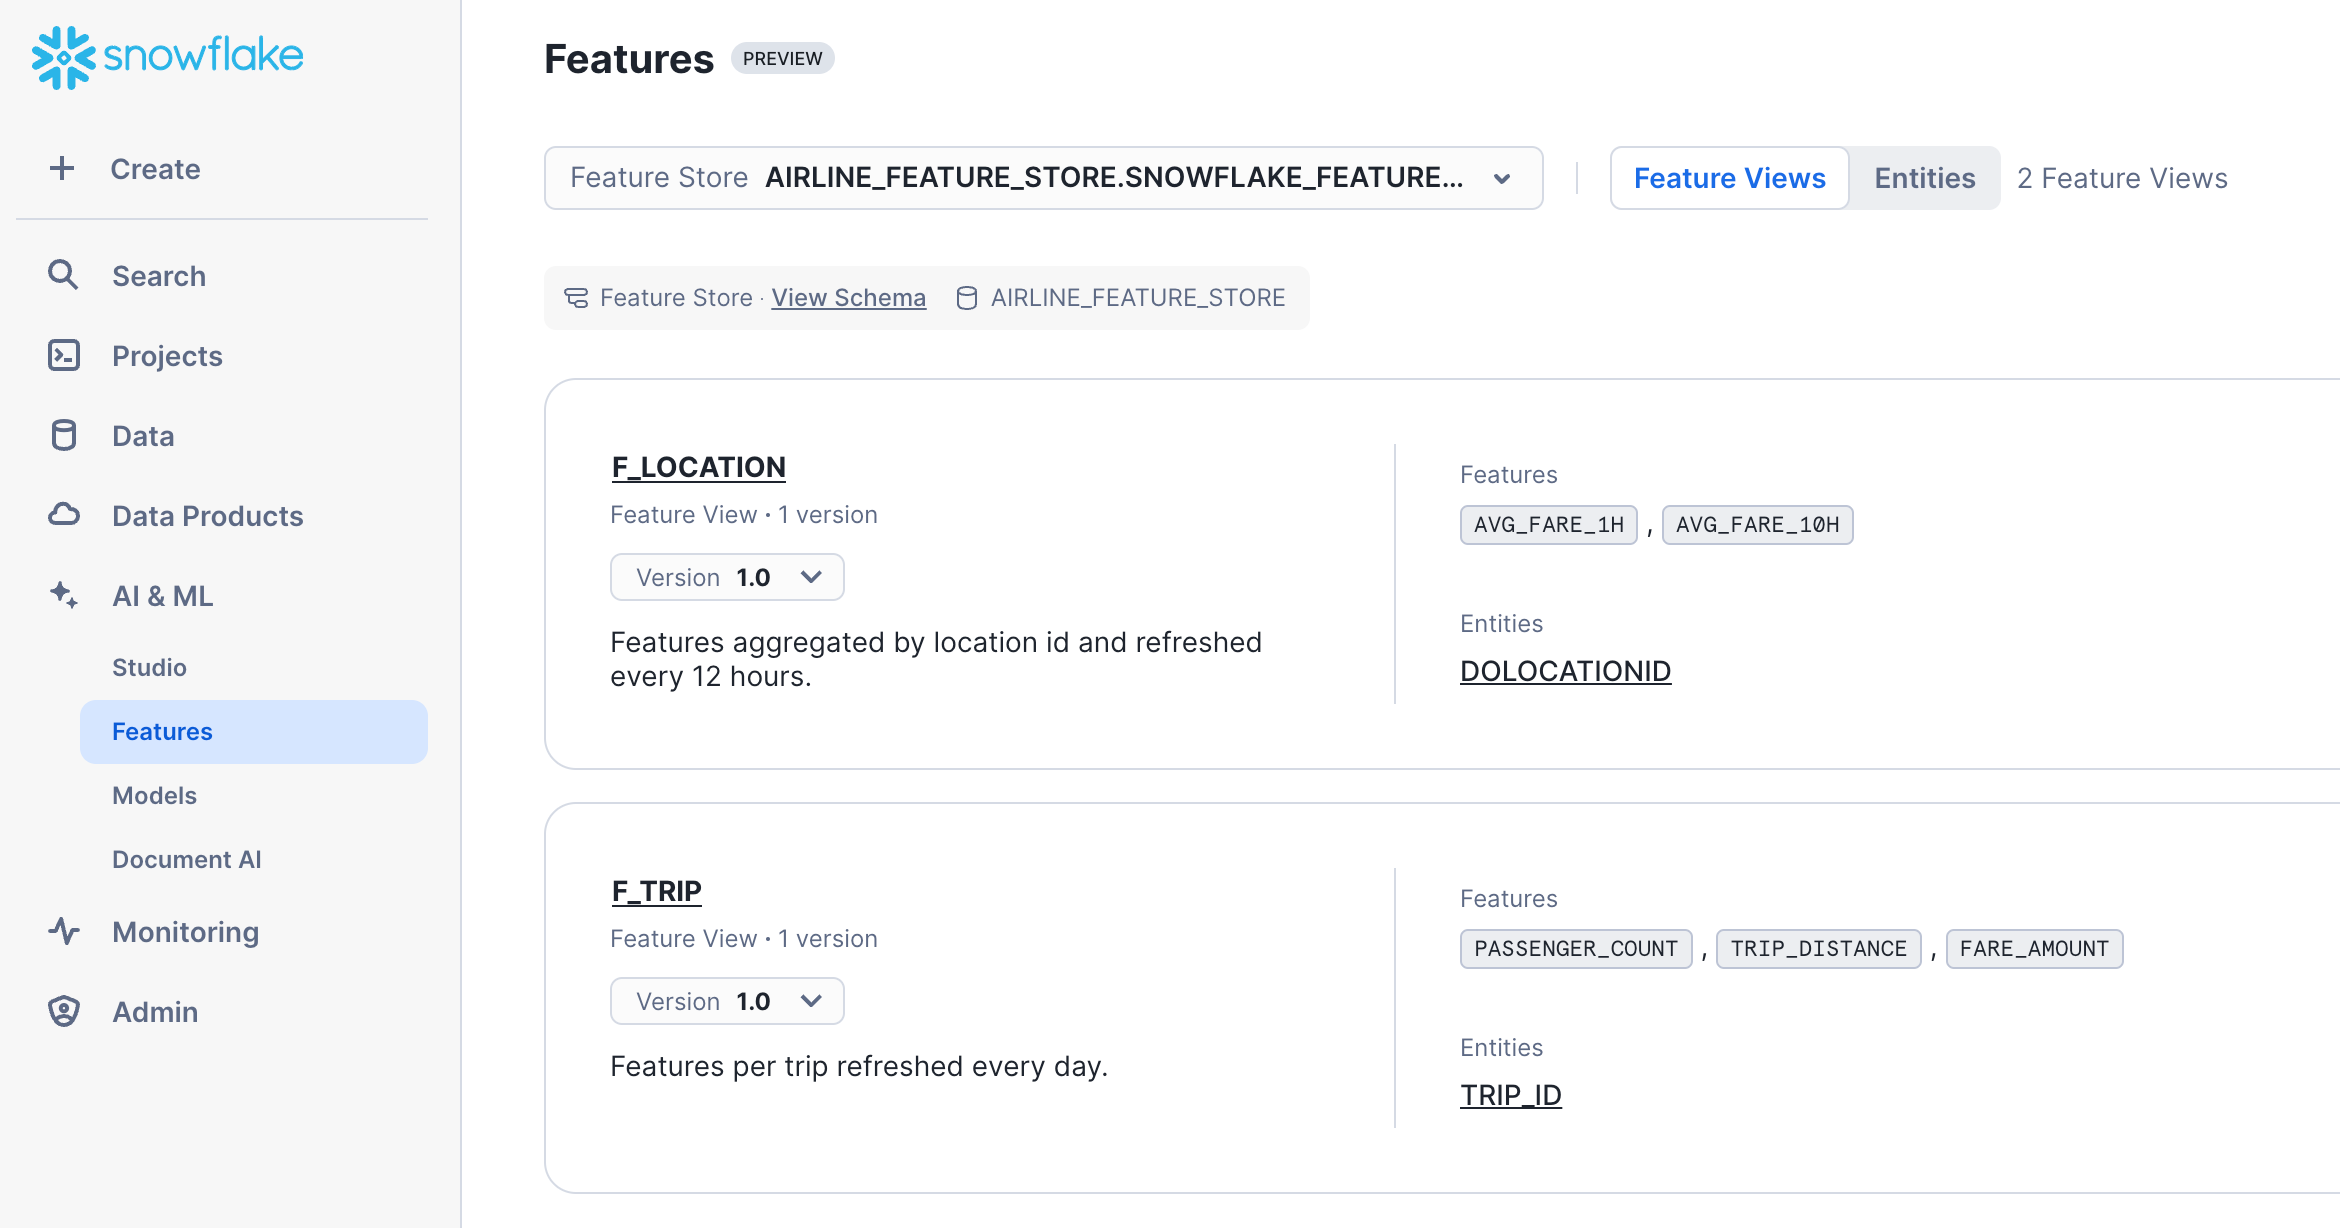

<a id='gen-training-data'></a>
## Generate Training Data

After our feature pipelines are fully setup, we can use them to generate [Snowflake Dataset](https://docs.snowflake.com/en/developer-guide/snowpark-ml/dataset) and later do model training. Generating training data is easy since materialized FeatureViews already carry most of the metadata like join keys, timestamp for point-in-time lookup, etc. We just need to provide the spine data (it's called spine because it is the list of entity IDs that we are essentially enriching by joining features with it).

`generate_dataset()` returns a Snowflake Dataset object, which is best for distributed training with deep learning frameworks like TensorFlow or Pytorch which requires fine-grained file-level access. It creates a new Dataset object (which is versioned and immutable) in Snowflake which materializes the data in Parquet files. If you train models with classic ML libraries like Snowpark ML or scikit-learn, you can use `generate_training_set()` which returns a classic Snowflake table. The Cell below demonstrates `generate_dataset()`.

Retrieve some metadata columns that are essential when generating training data.

In [9]:
label_cols = example_helper.get_label_cols()
timestamp_col = example_helper.get_training_data_timestamp_col()
excluded_cols = example_helper.get_excluded_cols()
join_keys = [key for entity in all_entities for key in entity.join_keys]
spine_table = example_helper.get_training_spine_table()
print(f'timestamp col: {timestamp_col}')
print(f'excluded cols: {excluded_cols}')
print(f'label cols: {label_cols}')
print(f'join keys: {join_keys}')
print(f'training spine table: {spine_table}')

timestamp col: TPEP_PICKUP_DATETIME
excluded cols: []
label cols: ['TOTAL_AMOUNT']
join keys: ['TRIP_ID', 'DOLOCATIONID']
training spine table: "AIRLINE_FEATURE_STORE".SNOWFLAKE_FEATURE_STORE_NOTEBOOK_DEMO.nyc_yellow_trips


Create a spine dataframe that's sampled from source table.

In [10]:
sample_count = 512
source_df = session.table(spine_table).select(
    label_cols + join_keys + [timestamp_col] if timestamp_col else []
)
spine_df = source_df.sample(n=sample_count)
# preview spine dataframe
spine_df.show()

------------------------------------------------------------------------
|"TOTAL_AMOUNT"  |"TRIP_ID"  |"DOLOCATIONID"  |"TPEP_PICKUP_DATETIME"  |
------------------------------------------------------------------------
|11.8            |4391772    |236             |2016-01-13 15:28:31     |
|6.8             |9640580    |231             |2016-01-28 21:47:03     |
|10.3            |8986296    |162             |2016-01-27 06:44:50     |
|20.35           |4689446    |261             |2016-01-14 09:29:27     |
|19.89           |9360850    |166             |2016-01-28 07:33:07     |
|6.3             |9335036    |211             |2016-01-28 04:46:46     |
|72.92           |5223446    |264             |2016-01-15 17:21:27     |
|16.3            |4578405    |116             |2016-01-13 23:35:00     |
|7.3             |5045083    |163             |2016-01-15 07:10:06     |
|10.3            |9733135    |145             |2016-01-29 05:14:06     |
---------------------------------------------------

Generate dataset object from spine dataframe and feature views.

In [11]:
my_dataset = fs.generate_dataset(
    name="my_cool_training_dataset",
    spine_df=spine_df, 
    features=all_feature_views,
    version="4.0",
    spine_timestamp_col=timestamp_col,
    spine_label_cols=label_cols,
    exclude_columns=excluded_cols,
    desc="This is the dataset joined spine dataframe with feature views",
)

Convert dataset to a snowpark dataframe and examine all the features in it.

In [12]:
training_data_df = my_dataset.read.to_snowpark_dataframe()
assert training_data_df.count() == sample_count
# drop rows that have any nulls in value. 
training_data_df = training_data_df.dropna(how='any')
training_data_df.to_pandas()

,TOTAL_AMOUNT,TRIP_ID,DOLOCATIONID,TPEP_PICKUP_DATETIME,AVG_FARE_1H,AVG_FARE_10H,PASSENGER_COUNT,TRIP_DISTANCE,FARE_AMOUNT
0,6.300000,9753533,228,2016-01-29 07:50:17-08:00,42.083332,25.560465,1,0.800000,5.5
1,-4.800000,337386,161,2016-01-01 23:27:54-08:00,9.713513,10.708535,2,0.150000,-3.5
2,12.250000,521354,161,2016-01-02 16:00:37-08:00,10.513055,9.510478,3,1.110000,9.0
3,18.799999,536727,161,2016-01-02 17:30:49-08:00,11.397975,9.790948,5,2.500000,16.0
4,15.300000,1059372,161,2016-01-04 11:12:42-08:00,10.893401,9.468452,1,2.500000,12.5
...,...,...,...,...,...,...,...,...,...
507,38.299999,371165,244,2016-01-02 02:56:18-08:00,23.259615,22.674618,1,13.300000,37.0
508,21.799999,4212437,244,2016-01-13 04:03:58-08:00,22.120001,22.395477,1,7.170000,20.5
509,42.349998,7530490,244,2016-01-21 17:51:06-08:00,25.574074,23.103773,1,7.900000,33.5
510,14.300000,7304440,4,2016-01-21 03:12:42-08:00,8.818182,10.719931,1,2.680000,12.0


<a id='train-with-snowpark-ml'></a>
## Train model with Snowpark ML

Now let's train a simple random forest model, and evaluate the prediction accuracy. When you call fit() on a DataFrame that is created from a  Dataset, the linkage between the trained model and dataset is automatically wired up. Later, you can easily retrieve the training dataset from this model, or you can query the lineage about the dataset and model. This is work-in-progress and will be available  soon in an upcoming release.

In [13]:
from snowflake.ml.modeling.ensemble import RandomForestRegressor
from snowflake.ml.modeling import metrics as snowml_metrics
from snowflake.snowpark.functions import abs as sp_abs, mean, col

def train_model_using_snowpark_ml(training_data_df):
    train, test = training_data_df.random_split([0.8, 0.2], seed=42)
    feature_columns = list(set(training_data_df.columns) - set(label_cols) - set(join_keys) - set([timestamp_col]))
    print(f"feature cols: {feature_columns}")
    
    rf = RandomForestRegressor(
        input_cols=feature_columns, label_cols=label_cols, 
        max_depth=3, n_estimators=20, random_state=42
    )

    rf.fit(train)
    predictions = rf.predict(test)

    output_label_names = ['OUTPUT_' + col for col in label_cols]
    mse = snowml_metrics.mean_squared_error(
        df=predictions, 
        y_true_col_names=label_cols, 
        y_pred_col_names=output_label_names
    )

    accuracy = 100 - snowml_metrics.mean_absolute_percentage_error(
        df=predictions,
        y_true_col_names=label_cols,
        y_pred_col_names=output_label_names
    )

    print(f"MSE: {mse}, Accuracy: {accuracy}")
    return rf

random_forest_model = train_model_using_snowpark_ml(training_data_df) 

feature cols: ['TRIP_DISTANCE', 'FARE_AMOUNT', 'AVG_FARE_10H', 'PASSENGER_COUNT', 'AVG_FARE_1H']
MSE: 8.587654420611477, Accuracy: 99.83667856616516


<a id="log-models-in-model-registry"></a>
## Log model in Model Registry

After the model is trained, we can save the model into Model Registry so we can manage the model, its metadata including metrics, versions, and use it later for inference. Also, ML lineage is built automatically between the model, dataset and feature views.

In [14]:
from snowflake.ml.registry import Registry

registry = Registry(
    session=session, 
    database_name=session.get_current_database(), 
    schema_name=MODEL_DEMO_SCHEMA,
)

Log model into Model Registry.

In [15]:
model_name = "MY_RANDOM_FOREST_REGRESSOR_MODEL"

registry.log_model(
    model_name=model_name,
    version_name="v1",
    model=random_forest_model,
    comment="My model trained with feature views, dataset",
)

/Users/wezhou/miniconda3/envs/py38/lib/python3.8/contextlib.py:113: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  return next(self.gen)


ModelVersion(
  name='MY_RANDOM_FOREST_REGRESSOR_MODEL',
  version='V1',
)

<a id="examine-model-in-snowflake-ui"></a>
### Examine model in Snowflake UI
Now you should be able to see the model in Snowflake UI.

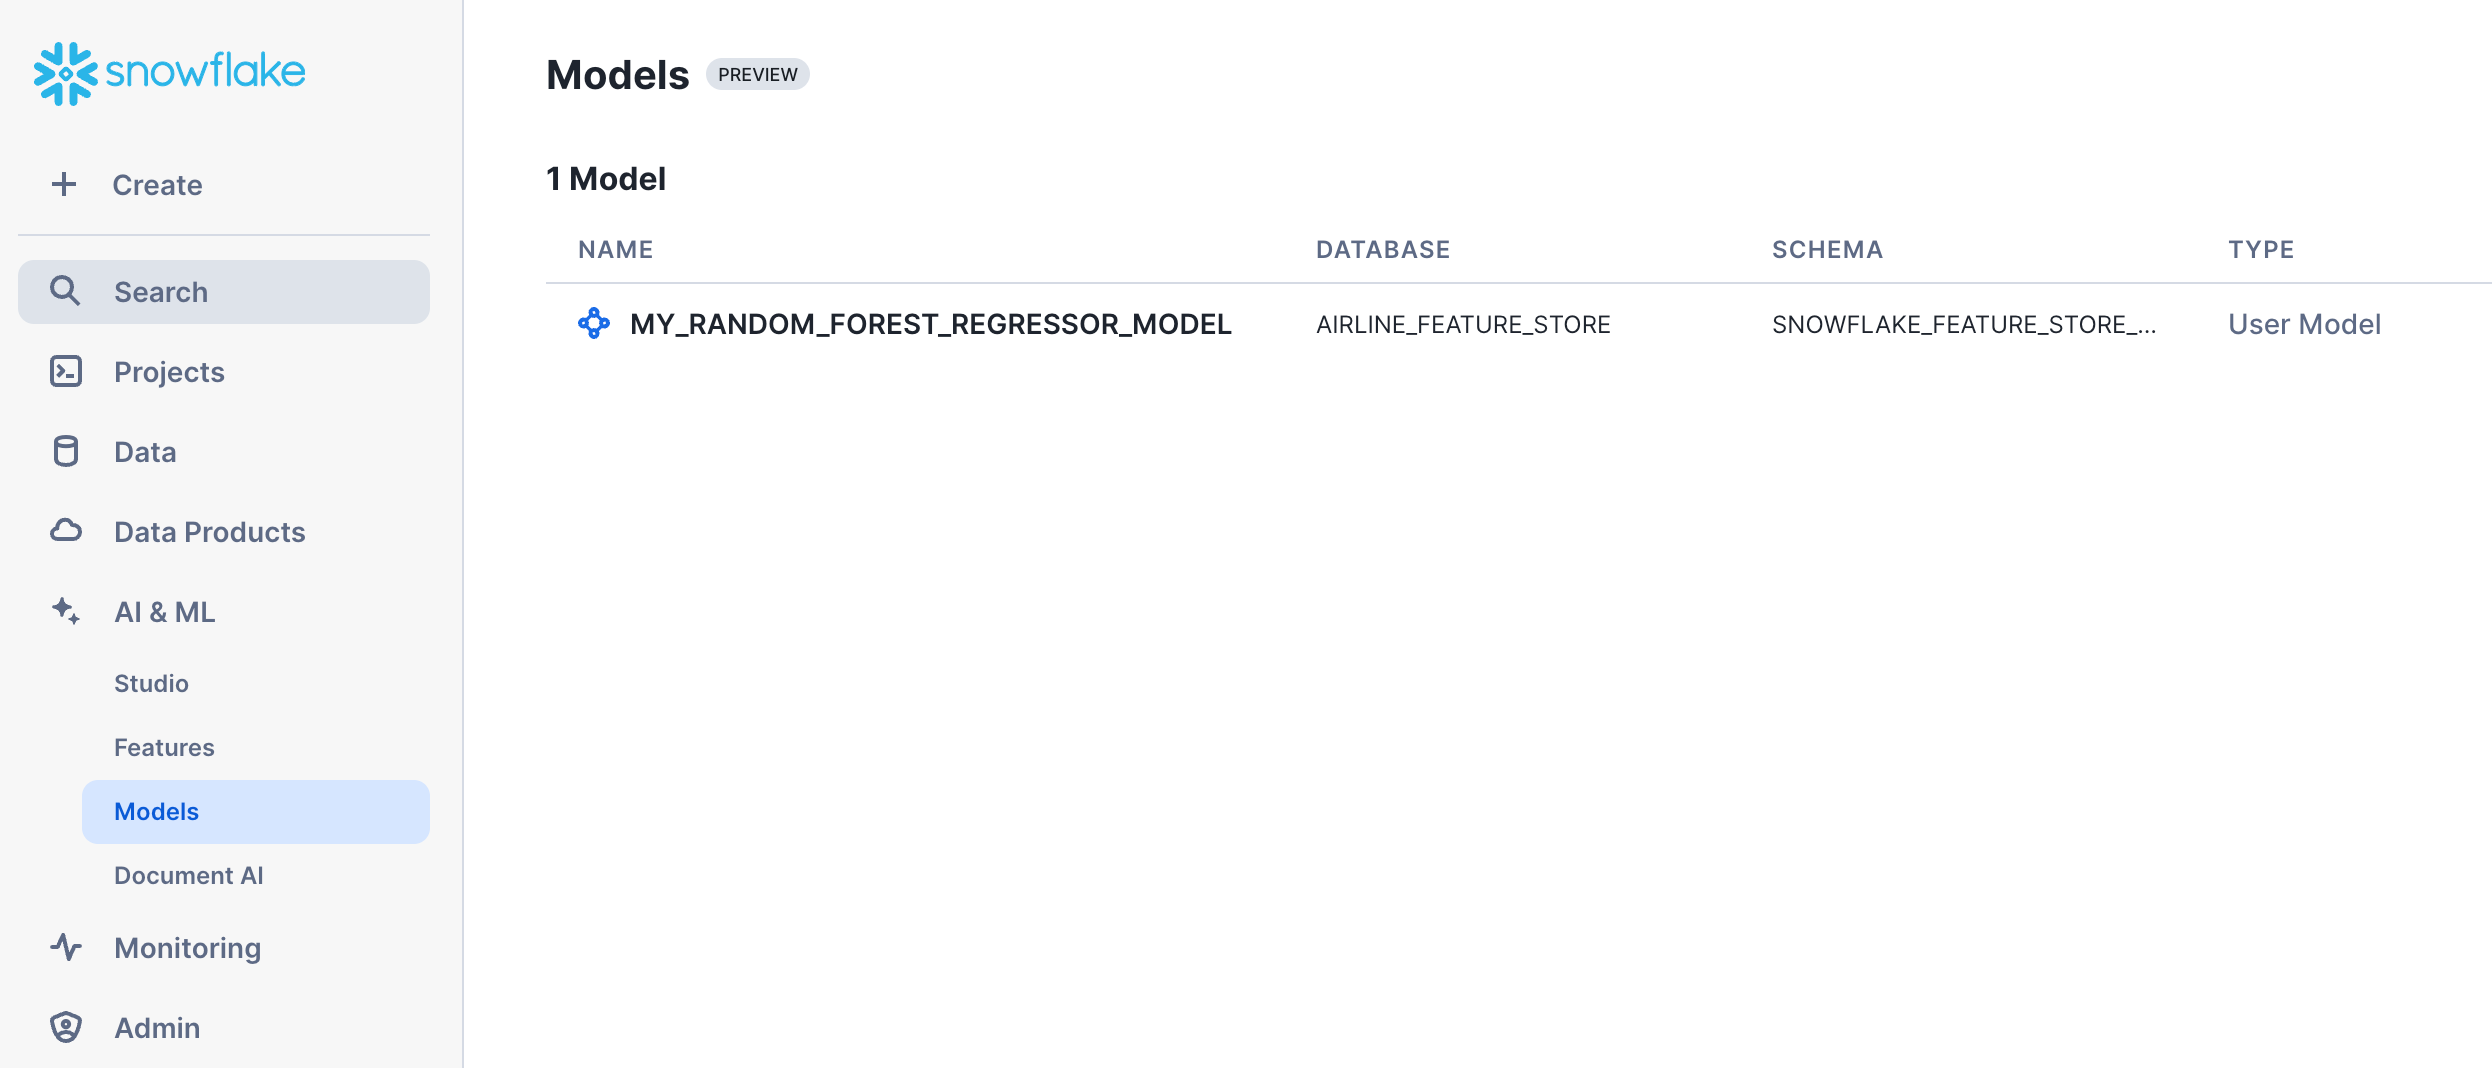

<a id="query-lineage"></a>
## Query lineage
We can now query the lineage from an object. You can call `lineage()` on any object and it returns a set of objects that it has dependency with.

In [16]:
model = registry.get_model(model_name).version("v1")
model.lineage(direction="upstream")

[Dataset(
   name='AIRLINE_FEATURE_STORE.SNOWFLAKE_FEATURE_STORE_NOTEBOOK_DEMO.MY_COOL_TRAINING_DATASET',
   version='4.0',
 )]

In [17]:
my_dataset.lineage(direction="downstream")

[ModelVersion(
   name='MY_RANDOM_FOREST_REGRESSOR_MODEL',
   version='V1',
 )]

In [18]:
for fv in all_feature_views:
    print(fv.lineage(direction='downstream'))

[Dataset(
  name='AIRLINE_FEATURE_STORE.SNOWFLAKE_FEATURE_STORE_NOTEBOOK_DEMO.MY_COOL_TRAINING_DATASET',
  version='4.0',
)]
[Dataset(
  name='AIRLINE_FEATURE_STORE.SNOWFLAKE_FEATURE_STORE_NOTEBOOK_DEMO.MY_COOL_TRAINING_DATASET',
  version='4.0',
)]


<a id='predict-with-model'></a>
## Predict with model

Finally we are almost ready for prediction! For this, we can look up the latest feature values from Feature Store for the specific data records that we are running prediction on. One of the key benefits of using the Feature Store is that it provides a way to automatically serve up the right feature values during prediction with point-in-time correct feature values. `load_feature_views_from_dataset()` gets the same feature views used in training, then `retrieve_feature_values()` lookups the latest feature values.

In [19]:
test_df = source_df.sample(n=3)

# load back feature views from dataset
fvs = fs.load_feature_views_from_dataset(my_dataset)
enriched_df = fs.retrieve_feature_values(
    test_df, 
    features=fvs,
    exclude_columns=join_keys,
    spine_timestamp_col=timestamp_col
)
enriched_df = enriched_df.drop(join_keys)
enriched_pd = enriched_df.to_pandas()

<a id='predict-with-local-model'></a>
### [Optional 1] predict with local model
Now we can predict with a local model and the feature values retrieved from feature store. 

In [20]:
pred = random_forest_model.predict(enriched_pd)
print(pred)

   TOTAL_AMOUNT TPEP_PICKUP_DATETIME  AVG_FARE_1H  AVG_FARE_10H  \
0         15.96  2016-01-07 10:26:02     9.440415      9.324965   
1         10.55  2016-01-01 18:44:40    10.083333      9.236685   
2         17.80  2016-01-29 21:05:54    10.385390     10.287410   

   PASSENGER_COUNT  TRIP_DISTANCE  FARE_AMOUNT  OUTPUT_TOTAL_AMOUNT  
0                1           2.23         12.5            16.440312  
1                1           1.70          7.0             8.523669  
2                1           3.11         16.5            18.717726  


<a id='predict-with-model-registry'></a>
### [Option 2] Predict with Model Registry

We can also retrieve the model from model registry and run  predictions on the model using latest feature values.

In [21]:
# model is retrieved from Model Registry in earlier step.
restored_prediction = model.run(enriched_pd, function_name="predict")
print(restored_prediction)

   TRIP_DISTANCE  FARE_AMOUNT  AVG_FARE_10H  PASSENGER_COUNT  AVG_FARE_1H  \
0           2.23         12.5      9.324965                1     9.440415   
1           1.70          7.0      9.236685                1    10.083333   
2           3.11         16.5     10.287410                1    10.385390   

   OUTPUT_TOTAL_AMOUNT  
0            16.440312  
1             8.523669  
2            18.717726  


<a id='cleanup'></a>
## Clean up notebook

This cell will drop the schemas have been created at beginning of this notebook, and also drop all objects live in the schemas including source data tables, feature views, datasets, and models.

In [22]:
session.sql(f"DROP SCHEMA IF EXISTS {FS_DEMO_SCHEMA}").collect()
session.sql(f"DROP SCHEMA IF EXISTS {MODEL_DEMO_SCHEMA}").collect()

[Row(status='SNOWFLAKE_FEATURE_STORE_NOTEBOOK_DEMO_MODEL successfully dropped.')]